# Download Daymet

Daymet provides gridded meteorological data for North American at 1km spatial resolution with daily timestep from 1980 ~ present. [website](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1328) and [user guide](https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html)

Available variables:

| Variable | Description (units) |
| ---- | ---- |
| tmax | Daily maximum 2-meter air temperature (°C) |
| tmin | Daily minimum 2-meter air temperature (°C) |
| prcp | Daily total precipitation (mm/day) |
| srad | Incident shortwave radiation flux density (W/m2) |
| vp   | Water vapor pressure (Pa) |
| swe  | Snow water equivalent (kg/m2) |
| dayl | Duration of the daylight period (seconds/day) |

Notes:
 - The Daymet calendar is based on a standard calendar year. All Daymet years, including leap years, have 1 - 365 days. For leap years, the Daymet database includes leap day (February 29) and values for December 31 are discarded from leap years to maintain a 365-day year.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
import sys
sys.path.append("./")
sys.path.append("../../watershed-workflow")
sys.path.append("../workflow_tpls")
sys.path.append("../workflow")

import workflow
import workflow.ui
import logging
workflow.ui.setup_logging(1,None)

import numpy as np
import rasterio
import fiona
import workflow.daymet

In [3]:
watershed_shapefile = '../data/hydrologic_units/others/CoalCreek/CoalCreek.shp'

## import watershed

2021-04-22 11:02:32,386 - root - INFO: 
2021-04-22 11:02:32,386 - root - INFO: Preprocessing Shapes
2021-04-22 11:02:32,387 - root - INFO: ------------------------------
2021-04-22 11:02:32,387 - root - INFO: loading file: "../data/hydrologic_units/others/CoalCreek/CoalCreek.shp"
2021-04-22 11:02:32,400 - root - INFO: crs: EPSG:26913


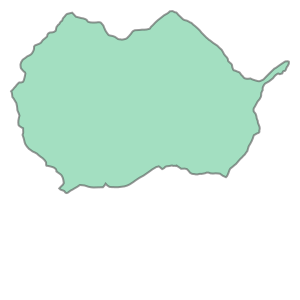

In [4]:
crs, watershed = workflow.get_split_form_shapes(watershed_shapefile)
logging.info(f'crs: {crs}')

bounds = watershed.exterior()
bounds

## Download

returned raw data has `dim(nband, ncol, nrow)`

In [5]:
startdate = "1-1980"
enddate = "365-1980"

In [8]:
# setting vars = None to download all available variables
raw, x, y = workflow.daymet.collectDaymet( bounds, start = startdate, end = enddate, 
                                          crs = crs, vars=None, force = False, combine = True)

2021-04-22 11:03:24,166 - root - INFO: downloading variables: ['tmin', 'tmax', 'prcp', 'srad', 'vp', 'swe', 'dayl']
2021-04-22 11:03:24,292 - root - INFO: Collecting DayMet file to tile bounds: [-107.11634327399999, 38.817702882000034, -106.96736104899996, 38.904775007000076]
2021-04-22 11:03:24,292 - root - INFO:   Using existing: /Users/shua784/github/workflow-test/examples/data/meteorology/daymet/daymet_tmin_1980_38.904775007000076x-107.11634327399999_38.817702882000034x-106.96736104899996.nc
2021-04-22 11:03:24,391 - root - INFO: Collecting DayMet file to tile bounds: [-107.11634327399999, 38.817702882000034, -106.96736104899996, 38.904775007000076]
2021-04-22 11:03:24,392 - root - INFO:   Using existing: /Users/shua784/github/workflow-test/examples/data/meteorology/daymet/daymet_tmax_1980_38.904775007000076x-107.11634327399999_38.817702882000034x-106.96736104899996.nc
2021-04-22 11:03:24,492 - root - INFO: Collecting DayMet file to tile bounds: [-107.11634327399999, 38.81770288200

## Reproject Daymet CRS

Reproject daymet CRS to the same as the watershed. This is necessary if watershed meshes are using watershed CRS.

In [9]:
new_x, new_y, new_extent, new_dat, daymet_profile = workflow.daymet.reproj_Daymet(x, y, raw,  dst_crs = crs)

2021-04-22 11:03:50,988 - root - INFO: daymet profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 14, 'height': 11, 'count': 365, 'crs': CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(1000.0, 0.0, -590750.0,
       0.0, -1000.0, -355500.0), 'tiled': False, 'interleave': 'pixel'}
2021-04-22 11:03:50,989 - root - INFO: reprojecting to new crs: EPSG:26913
2021-04-22 11:03:51,247 - root - INFO: new profil

## plot Daymet

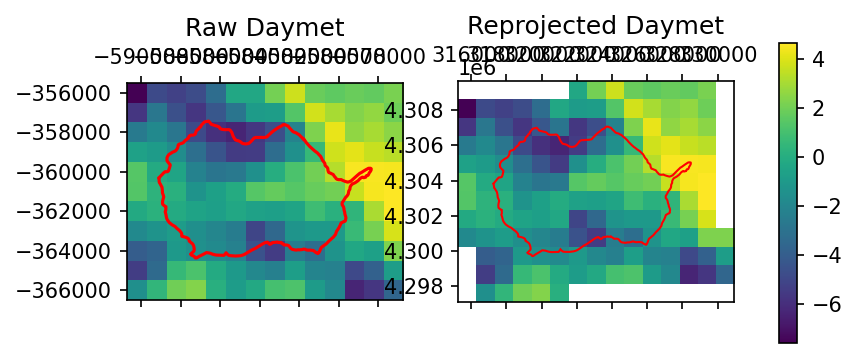

In [12]:
ivar = 'tmax'
islice = 100
fig, axes = plt.subplots(1, 2)

ax = axes[0]
extent = rasterio.transform.array_bounds(daymet_profile['height'], daymet_profile['width'], daymet_profile['transform']) # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3]

iraster = raw[ivar][islice, :, :]

with fiona.open(watershed_shapefile, mode='r') as fid:
    bnd_profile = fid.profile
    bnd = [r for (i,r) in fid.items()]
daymet_crs = workflow.crs.daymet_crs()

# convert to destination crs
native_crs = workflow.crs.from_fiona(bnd_profile['crs'])
reproj_bnd = workflow.warp.shape(bnd[0], native_crs, daymet_crs)
reproj_bnd_shply = workflow.utils.shply(reproj_bnd)

cax = ax.matshow(iraster, extent=plot_extent, alpha=1)
ax.plot(*reproj_bnd_shply.exterior.xy, 'r')
ax.set_title("Raw Daymet")


ax = axes[1]
extent = new_extent # (x0, y0, x1, y1)
plot_extent = extent[0], extent[2], extent[1], extent[3] # (x0, x1, y0, y1)

iraster = new_dat[ivar][islice, :, :]

# set nodata to NaN to avoid plotting
iraster[iraster == -9999] = np.nan

workflow.plot.hucs(watershed, crs, ax=ax, color='r', linewidth=1)
im = ax.matshow(iraster, extent=plot_extent)
ax.set_title("Reprojected Daymet")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax)

# save daymet

## Write to HDF5

Write raw daymet data to a single HDF5 file.

In [13]:
workflow.daymet.writeHDF5(new_dat, new_x, new_y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'watershed_daymet-raw.h5')

2021-04-22 11:04:02,759 - root - INFO: Writing HDF5 file: watershed_daymet-raw.h5


## Write to ATS format

This will write daymet in a format that ATS can read. E.g., this will partition precipitation into rain and snow, convert vapor pressure to relative humidity, get mean air temperature and so on.

- dout has dims of `(ntime, nrow, ncol)` or `(ntime, ny, nx)`

In [14]:
workflow.daymet.writeATS(new_dat, new_x, new_y, 
                         workflow.daymet.getAttrs(bounds.bounds, startdate, enddate), 
                         'watershed_daymet-ats.h5')

2021-04-22 11:04:06,334 - root - INFO: Writing ATS file: watershed_daymet-ats.h5
2021-04-22 11:04:06,334 - root - INFO: input dat shape: (365, 12, 15)
2021-04-22 11:04:06,335 - root - INFO: Converting to ATS met input
